In [2]:
import pybamm as pb;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
for k in range(0,1):
    mpl.rcParams["axes.labelsize"] = fs
    mpl.rcParams["axes.titlesize"] = fs
    mpl.rcParams["xtick.labelsize"] =  fs
    mpl.rcParams["ytick.labelsize"] =  fs
    mpl.rcParams["legend.fontsize"] =  fs
    mpl.rcParams['font.sans-serif'] = ['Times New Roman']
    mpl.rcParams['font.serif'] = ['Times New Roman']
    mpl.rcParams['axes.unicode_minus'] = False

import openpyxl

In [3]:
from pybamm import exp, constants, Parameter
def nmc_LGM50_electrolyte_exchange_current_density_ORegan2021_adjust(c_e, c_s_surf, T):
    i_ref = 5.028  # (A/m2)
    alpha = 0.43
    E_r = 2.401e4
    arrhenius = exp(E_r / constants.R * (1 / 298.15 - 1 / T))
    c_p_max = Parameter("Maximum concentration in positive electrode [mol.m-3]")
    c_e_ref = Parameter("Typical electrolyte concentration [mol.m-3]")
    return (
        i_ref
        * arrhenius
        * (c_e / c_e_ref) ** (1 - alpha)
        * (c_s_surf / c_p_max) ** alpha
        * (1 - c_s_surf / c_p_max) ** (1 - alpha))

def nmc_LGM50_diffusivity_ORegan2021_adjust(sto, T):
    a1 = -0.9231
    a2 = -0.4066
    a3 = -0.993
    b1 = 0.3216
    b2 = 0.4532
    b3 = 0.8098
    c0 = -13.96
    c1 = 0.002534
    c2 = 0.003926
    c3 = 0.09924
    d = 1449

    D_ref = (
        10
        ** (
            c0
            + a1 * exp(-((sto - b1) ** 2) / c1)
            + a2 * exp(-((sto - b2) ** 2) / c2)
            + a3 * exp(-((sto - b3) ** 2) / c3)
        )
        * 10  # correcting factor (see O'Regan et al 2021), mark Ruihe change from 2.7 to 10
    )

    E_D_s = d * constants.R
    arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))

    return D_ref * arrhenius

def graphite_LGM50_diffusivity_ORegan2021_adjust(sto, T):
    a0 = 11.17
    a1 = -1.553
    a2 = -6.136
    a3 = -9.725
    a4 = 1.85
    b1 = 0.2031
    b2 = 0.5375
    b3 = 0.9144
    b4 = 0.5953
    c0 = -15.11
    c1 = 0.0006091
    c2 = 0.06438
    c3 = 0.0578
    c4 = 0.001356
    d = 2092

    D_ref = (
        10
        ** (
            a0 * sto
            + c0
            + a1 * exp(-((sto - b1) ** 2) / c1)
            + a2 * exp(-((sto - b2) ** 2) / c2)
            + a3 * exp(-((sto - b3) ** 2) / c3)
            + a4 * exp(-((sto - b4) ** 2) / c4)
        )
        * 20  # correcting factor (see O'Regan et al 2021) mark: Ruihe change from 3.0321 
    )

    E_D_s = d * constants.R
    arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))

    return D_ref * arrhenius

def graphite_LGM50_electrolyte_exchange_current_density_ORegan2021_adjust(c_e, c_s_surf, T):
    i_ref = 12.4  # (A/m2) replaced with value from Schmalstieg et al. (2018), from 2.668 
    alpha = 0.792
    E_r = 4e4
    arrhenius = exp(E_r / constants.R * (1 / 298.15 - 1 / T))

    c_n_max = Parameter("Maximum concentration in negative electrode [mol.m-3]")
    c_e_ref = Parameter("Typical electrolyte concentration [mol.m-3]")

    return (
        i_ref
        * arrhenius
        * (c_e / c_e_ref) ** (1 - alpha)
        * (c_s_surf / c_n_max) ** alpha
        * (1 - c_s_surf / c_n_max) ** (1 - alpha))

def nmc_LGM50_electronic_conductivity_ORegan2021_adjust(T):
    E_r = 3.5e3
    arrhenius = exp(E_r / constants.R * (1 / 298.15 - 1 / T))

    sigma = 0.8473 * arrhenius

    return sigma


In [4]:
def RunModel_basedon_last( Sol_old,Model_old,exp_list,cycle_number,  para,var_pts):
    Model_new = (
        Model_old.set_initial_conditions_from(
            Sol_old, inplace=False
            ))
    Sim_new    = pb.Simulation(
        Model_new,        experiment = pb.Experiment( exp_list *cycle_number ),
        parameter_values = para,
        solver = pb.CasadiSolver(),
        var_pts=var_pts,
        ) 
    Sol_new   = Sim_new.solve(calc_esoh=False)
    return Sol_new,Model_new

In [5]:
# Test this branch - Coupled_RioP2 newly created from Simon's develop branch
# Run without dry-out model
V_max = 4.2;        V_min = 2.5;   Temper_RPT = 25; 
Total_Cycles = 10; save_at_cycles = 1;  
for i in range(0,1):  # Key scan parameters:
    Diff_SEI_i = 1.7e-20; 
    R_SEI_i = 2E5;   Bulk_Sol_Con_i = 4541.0;
    D_Li_inSEI_i = 1e-22;    # default: 1e-20 
    c_Li_inte_ref_i = 15;    # default: 15
    Diff_EC_i   = 2e-20;       k_SEI_i   = 1e-16;
    LAMcr_prop_i=2.7778e-09;   Crack_rate_i=3.9e-20; 
    Couple_SEI_LiP_i = 1e-6; # default: 1e-6
    k_LiP_i = 1E-10;         # default: 1e-10
    Temper = 25;
    mesh_par = 120;

exp_AGE_text = [(f"Discharge at 1 C until {V_min} V", 
        f"Charge at 0.3 C until {V_max} V", 
        f"Hold at {V_max} V until C/100"),  ]
exp_RPT_text = [ (f"Discharge at 0.1C until {V_min} V",  
        "Rest for 6 hours",  
        f"Charge at 0.1C until {V_max} V" ) ]

for i in range(0,1):  
    ChemistryChen=pb.parameter_sets.OKane2022   
    #ChemistryChen["electrolyte"] = "lipf6_Valoen2005"
    Para_0=pb.ParameterValues(chemistry=ChemistryChen)
    # DFN parameter
    Para_0.update({"Upper voltage cut-off [V]": 4.21})
    Para_0.update({"Lower voltage cut-off [V]": 2.49})
    Para_0.update({"Negative electrode diffusivity [m2.s-1]": 2e-14})
    Para_0.update({"Positive electrode diffusivity [m2.s-1]": 1e-14})
    # general SEI
    Para_0.update({'SEI resistivity [Ohm.m]':R_SEI_i}) ;
    # solvent-diffusion limited
    Para_0.update({'Outer SEI solvent diffusivity [m2.s-1]':Diff_SEI_i});
    Para_0.update({'Bulk solvent concentration [mol.m-3]':Bulk_Sol_Con_i});
    # interstitial-diffusion limited
    Para_0.update({'Inner SEI lithium interstitial diffusivity [m2.s-1]':D_Li_inSEI_i})       
    Para_0.update({'Lithium interstitial reference concentration [mol.m-3]':c_Li_inte_ref_i}) 
    # ec-reaction limited
    Para_0.update({'EC diffusivity [m2.s-1]':Diff_EC_i}) 
    Para_0.update({'SEI kinetic rate constant [m.s-1]':k_SEI_i}) 
    Para_0.update({'EC initial concentration in electrolyte [mol.m-3]':Bulk_Sol_Con_i}) 
    # LiP and coupling with SEI:
    Para_0.update({"Dead lithium decay constant [s-1]": Couple_SEI_LiP_i})   
    Para_0.update({'Lithium plating kinetic rate constant [m.s-1]':k_LiP_i})  
    # Crack model
    Para_0.update({"Negative electrode LAM constant proportional term [s-1]": LAMcr_prop_i})
    Para_0.update({"Positive electrode LAM constant proportional term [s-1]": LAMcr_prop_i})  
    # make it simple for now, but may want to have T dependency in the future
    Para_0.update({"Negative electrode cracking rate": Crack_rate_i})
    Para_0.update({"Positive electrode cracking rate": Crack_rate_i})
    Para_0.update({"Negative electrode volume change": 0.0})
    Para_0.update({"Positive electrode volume change": 0.0}) 
    Model_0 = pb.lithium_ion.DFN(      ) #
    var = pb.standard_spatial_vars  
    var_pts = {
        var.x_n: 20,  
        var.x_s: 10,  
        var.x_p: 20,  
        var.r_n: mesh_par,  
        var.r_p: mesh_par,  }

In [6]:
# Run break-in cycle
Sim_Breakin_0    = pb.Simulation(
    Model_0,        experiment =  pb.Experiment( exp_RPT_text *2 ),
    parameter_values = Para_0,
    solver = pb.CasadiSolver(),
    var_pts=var_pts,
    ) 
Sol_Breakin_0    = Sim_Breakin_0.solve(calc_esoh=False)

In [7]:
# Run 1st age cycle 
Sol_AGE_1,Model_AGE_1 = RunModel_basedon_last( 
    Sol_Breakin_0,Model_0,exp_AGE_text,3,  Para_0,var_pts)
# Run 1st RPT:
Sol_RPT_1,Model_RPT_1 = RunModel_basedon_last( 
    Sol_AGE_1,Model_AGE_1,exp_RPT_text,2,  Para_0,var_pts)

In [8]:
# Run 2nd age cycle 
Sol_AGE_2,Model_AGE_2 = RunModel_basedon_last( 
    Sol_RPT_1,Model_RPT_1,exp_AGE_text,3,  Para_0,var_pts)
# Run 2nd RPT:
Sol_RPT_2,Model_RPT_2 = RunModel_basedon_last( 
    Sol_AGE_2,Model_AGE_2,exp_RPT_text,2,  Para_0,var_pts)

In [9]:
# Run 3rd age cycle 
Sol_AGE_3,Model_AGE_3 = RunModel_basedon_last( 
    Sol_RPT_2,Model_RPT_2,exp_AGE_text,3,  Para_0,var_pts)
# Run 3rd RPT:
Sol_RPT_3,Model_RPT_3 = RunModel_basedon_last( 
    Sol_AGE_3,Model_AGE_3,exp_RPT_text,2,  Para_0,var_pts)

In [10]:
# Run 4th age cycle 
Sol_AGE_4,Model_AGE_4 = RunModel_basedon_last( 
    Sol_RPT_3,Model_RPT_3,  exp_AGE_text,3,  Para_0,var_pts)
# Run 4th RPT:
Sol_RPT_4,Model_RPT_4 = RunModel_basedon_last( 
    Sol_AGE_4,Model_AGE_4,exp_RPT_text,2,  Para_0,var_pts)


In [ ]:
# Run 5th age cycle 
Sol_AGE_5,Model_AGE_5 = RunModel_basedon_last( 
    Sol_RPT_4,Model_RPT_4,  exp_AGE_text,3,  Para_0,var_pts)
# Run 5th RPT:
Sol_RPT_5,Model_RPT_5 = RunModel_basedon_last( 
    Sol_AGE_5,Model_AGE_5,  exp_RPT_text,2,  Para_0,var_pts)


In [6]:
label = ["0",] 
output_variables3 = [
                "Electrolyte potential [V]",
                "Positive electrode potential [V]",
                "Negative electrode potential [V]",
                "Positive current collector potential [V]", 
                "Terminal voltage [V]", 
            ]
quick_plot = pb.QuickPlot([Sol_Breakin_0], output_variables3,label,variable_limits='tight') #     
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=0.0, description='t', max=52.00800167462465, step=0.5200800167462465),…

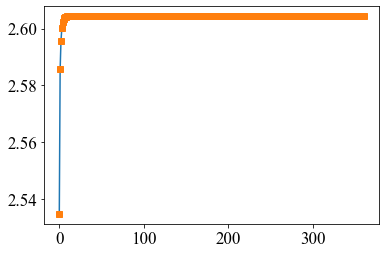

In [11]:
plt.plot(Sol_Breakin_0.cycles[0].steps[1]["Terminal voltage [V]"].entries,'-o')
plt.plot(Sol_Breakin_0.cycles[1].steps[1]["Terminal voltage [V]"].entries,'s')

In [ ]:
label = ["3","4"] 
output_variables3 = [
                "Minimum positive particle concentration",
                "Minimum negative particle concentration",
                "Maximum positive particle concentration",
                "Maximum negative particle concentration",
                "Maximum positive particle surface concentration",
                "Maximum negative particle surface concentration",
            ]
quick_plot = pb.QuickPlot([Sol_Breakin_3,Sol_Breakin_4], output_variables3,label,variable_limits='tight') #     
quick_plot.dynamic_plot();

In [ ]:
label = ["3","4"] 
output_variables3 = [
                "Positive particle surface concentration",
                "Negative particle surface concentration",
                "X-averaged electrolyte potential",
                "X-averaged electrolyte potential [V]"
            ]
quick_plot = pb.QuickPlot([Sol_Breakin_3,Sol_Breakin_4], output_variables3,label,variable_limits='tight') #     
quick_plot.dynamic_plot();

In [ ]:
label = ["3", "4"] 
output_variables3 = [
                "Negative electrode roughness ratio",
                "Positive electrode roughness ratio",
                "Total SEI on cracks thickness [m]",
                "X-averaged total SEI on cracks thickness [m]", 
                "X-averaged negative electrode roughness ratio",
                "Negative electrode capacity [A.h]",
                "Positive electrode capacity [A.h]",
            ]
quick_plot = pb.QuickPlot([Sol_Breakin_3,Sol_Breakin_4], output_variables3,label,variable_limits='tight') #     
quick_plot.dynamic_plot();

In [ ]:
label = ["2", "3"] 
output_variables3 = [
    "Loss of capacity to SEI [A.h]",
    "Loss of capacity to dead lithium plating [A.h]",
    "Loss of capacity to lithium plating [A.h]",
    "Loss of capacity to SEI on cracks [A.h]",
    ]
quick_plot = pb.QuickPlot([Sol_Breakin_2,Sol_Breakin_3], output_variables3,label,variable_limits='tight') #     
quick_plot.dynamic_plot();

In [ ]:
label = ["Sol_0","Sol_1"] 
output_variables3 = [
                "Discharge capacity [A.h]", 
                "Negative electrode SOC",
                "Positive electrode SOC",
                "Electrolyte potential [V]",
                "Negative particle surface concentration [mol.m-3]",
                "Terminal voltage [V]",
                "SEI interfacial current density [A.m-2]",
                "Porosity"
            ]
quick_plot = pb.QuickPlot([Sol_0,Sol_1], output_variables3,label,variable_limits='tight') #     
quick_plot.dynamic_plot();

In [ ]:
label = ["Diff_Li_SEI = 1e-18","Diff_Li_SEI = 1e-16"] 
output_variables3 = [
                "Discharge capacity [A.h]", 
                "Negative electrode SOC",
                "Positive electrode SOC",
                "Electrolyte potential [V]",
                "Negative particle surface concentration [mol.m-3]",
                "Terminal voltage [V]",
                "SEI interfacial current density [A.m-2]",
                "Porosity"
            ]
quick_plot = pb.QuickPlot([Sol_0,Sol_1], output_variables3,label,variable_limits='tight') #     
quick_plot.dynamic_plot();